In [1]:
!pip install pennylane --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 75.4 MB/s eta 0:00:00


# QML Basics

In this exercise we will explore the basics required for Quantum Machine Learning (QML).

As you learned in the lectures, a quantum program is given by a circuit, which is a diagrammatic representation of unitary transformations and measurements applied to a multi qubit system.

We will use the the open source package [Pennylane](https://pennylane.ai) to define circuits and simulate them.
Pennylane furthermore provides the tools needed to calculate gradients of parametrized quantum circuits and thus optimize a quantum program.

## A First Quantum circuit

As a first example, we would like to implement a circuit which creates a [Bell-State](https://en.wikipedia.org/wiki/Bell_state#Bell_basis)
$$\big|\psi\big> = \frac{\big|00\big> + \big|11\big>}{\sqrt{2}}.$$
To do so, we first import pennylane and numpy.
Note, that pennylane does contain a custom version of numpy (necessary for optimization of quantum circuits). When using pennylane always make sure you import pennylanes version of numpy.

In [2]:
import pennylane as qml
from pennylane import numpy as np

### Devices

To execute quantum circuits, we have to define a device.
A device specifies an object which can perform quantum operations and simulate measurements. Usually, we will choose between different simulators, but pennylane also provides plugins to connect to actual quantum computers.

There are many possible devices implemented in pennylane, a good standard choice is **lightning.qubit**.

In addition we have to specify the number of **wires**, which is the number of qubits we want to simulate.

A device like this will simulate a perfect quantum computer by calculating exact expectation values for measurements. If you want to simulate a more realistic scenario, where you run a quantum program a limited number of times, you can use the argument **shots**.

In [3]:
dev = qml.device("lightning.qubit", wires=2)

### QNodes

In pennylane a QNode is an object, which has a device assigned to it and a function specifying a quantum circuit.
The quantum circuit always has to return one or multiple measurements.

When calling a QNode, the assigned device is used to simulate the operations in the body of the QNode and return the measurement results.

You can construct a QNode just by creating a new object and passing passing it a function as circuit, however it is also possible to use the **@qml.qnode** decorator, which we will do here:

In [4]:
@qml.qnode(dev)
def circuit():
    pass

### Gates

To create the Bell state, we have to apply a [Hadamard](https://en.wikipedia.org/wiki/Quantum_logic_gate#Hadamard_gate) and a [CNOT gate](https://en.wikipedia.org/wiki/Quantum_logic_gate#Controlled_gates). We can do this by just calling the corresponding functions and specifying the wires they should be applied to.

In [5]:
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])

### Measurements

If you try to call the circuit function now, you will get an error, because we did not specify a measurement.

There are different possibilites for measurements in pennylane, here we will measure the expectation value of the first qubit (index 0) in the [PauliZ](https://en.wikipedia.org/wiki/Pauli_matrices) basis:

In [6]:
@qml.qnode(dev)
def final_circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    return qml.expval(qml.PauliZ(0))

We can plot our final QNode:

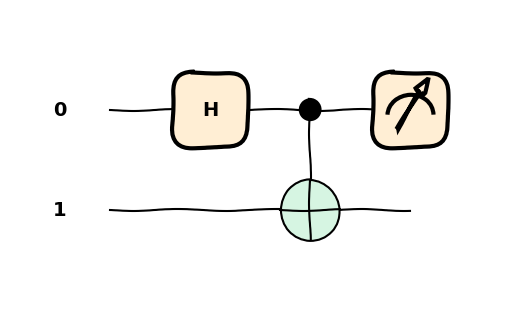

In [7]:
import matplotlib.pyplot as plt
qml.draw_mpl(final_circuit, decimals=1, style="sketch")()
plt.show()

To obtain a result for our program, we can just call the corresponding function _final_circuit_.
Since we are measuring the expectation value in the PauliZ basis (with eigenvalues -1 and 1) we expect to obtain 0 $\big(\frac{1}{2}\cdot 1 + \frac{1}{2}\cdot (-1) = 0\big)$

In [8]:
final_circuit()

tensor(0., requires_grad=True)

If specify the **shots** argument for our device, we can also use **qml.sample** instead of the expval to obtain a sample for the measurement.

In [9]:
sample_dev = qml.device("lightning.qubit", wires=2, shots=30)

@qml.qnode(sample_dev)
def sample_circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    return qml.sample(qml.PauliZ(0))

Lets look at the result:

([<matplotlib.axis.XTick at 0x7f15ed508310>,
 [Text(-1, 0, '−1'), Text(1, 0, '1')])

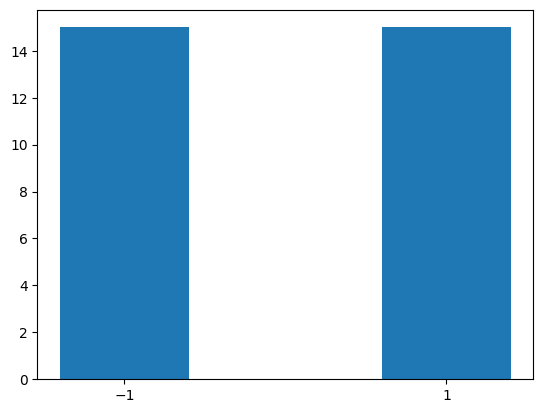

In [10]:
labels, counts = np.unique(sample_circuit(), return_counts=True)
plt.bar(labels, counts, align='center')
plt.xticks(labels)

Due to the finite sample size we do not get at perfect 50%/50% distribution.

### Exercise 1: Gates and circuits

Create and draw the following circuit using a QNode in pennylane:

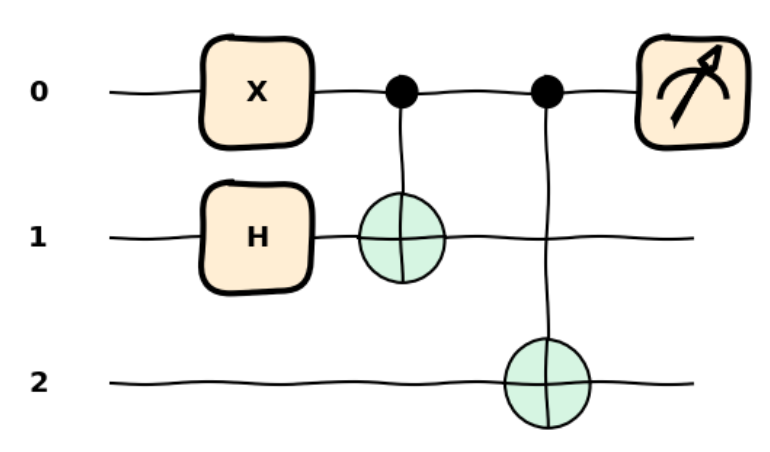

### Exercise 2: Gates and circuits

Write a circuit to create the three qubit [GHZ state](https://en.wikipedia.org/wiki/Greenberger–Horne–Zeilinger_state)
$$\frac{\big|\ 000\big> +\big|\ 111\big>}{\sqrt{2}}.$$

Think about how you can add a third qubit to the Bell state and fully entangle it. If you are unsure, you can check the [Wikipedia entry](https://en.wikipedia.org/wiki/Greenberger–Horne–Zeilinger_state).

Afterwards, measure all qubits in the Z basis and simulate the circuit with 1000 shots to verify that the outcome is what you expect.



## Calculating Gradients

We can create a parametrized quantum circuit (PQC) by giving the QNode function arguments. For example we can add two rotation gates with variable angles:

In [11]:
@qml.qnode(sample_dev)
def pqc(params):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    qml.RX(params[0], wires=0)
    qml.RX(params[1], wires=1)
    return qml.expval(qml.PauliZ(0))

When plotting this qnode, we have to pass the plotting function some values for the parameters.

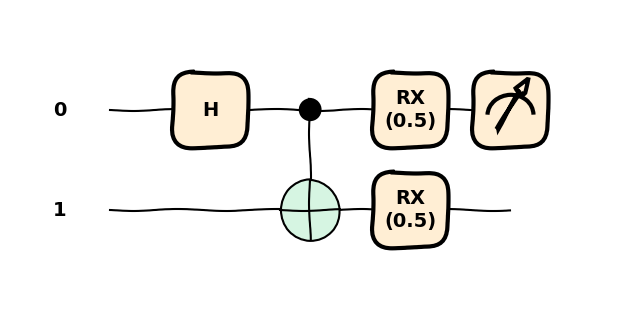

In [12]:
qml.draw_mpl(pqc, decimals=1, style="sketch")([0.5,0.5])
plt.show()

Pennylane implements the differentiation of PQCs with repect to any of its parameters.

On a simulator there are different methods of computing gradients of quantum circuits, one of the fastest beeing adjoint differentiation: https://arxiv.org/abs/2009.02823

On actual quantum hardware, it is also possible to compute gradients with the so called parameter shift rules: https://arxiv.org/abs/1811.11184

To calculate gradients in pennylane, we specify the argument to which we want to calculate the gradient to.

In [13]:
gradcircuit = qml.grad(pqc, argnum=0)

This returns a function with the gradient at any point

In [14]:
gradcircuit([0.5,0.5])

[array(0.06666667), array(0.)]

## Optimizing Quantum Circuits

Using the differentiation capabilies, pennylane also provides gradient based optimizers.

As an example we want to find an appoximation of the inverse of the Unitary transformation which creates the Bell state:
$$U_1\big|00\big> = \frac{\big|00\big>+\big|11\big>}{\sqrt{2}}$$

With $U_1 = (H\otimes I)CNOT$ it is analytically easy to see that $U_1 U_2 = I$ if $U_2=CNOT(H\otimes I)$

However as an example we would like to find an inverse by optimization.
We can do that by choosing a sufficiently expressive PQC as ansatz and optimizing the parameters to obtain $\big|00\big>$ in the end:

We define a QNode with a separate function for the $U_2$ ansatz.
In principle the ansatz can be anything, it should only be expressive enough to approximate the unitary in question.

In the end of our optimization circuit, we measure both qubits to check the results.

In [15]:
def U2ansatz(params):
    qml.RZ(params[0], wires=0)
    qml.RZ(params[1], wires=1)
    qml.CNOT(wires=[1,0])
    qml.RX(params[2], wires=0)
    qml.RX(params[3], wires=1)

@qml.qnode(dev)
def optimized_circuit(params):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    U2ansatz(params)
    return [qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))]

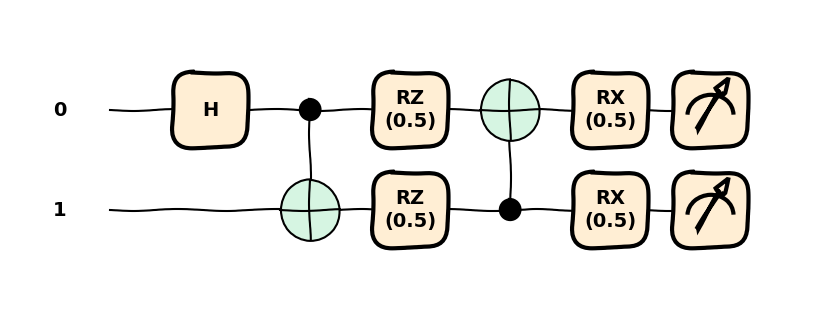

In [16]:
qml.draw_mpl(optimized_circuit, decimals=1, style="sketch")([0.5,0.5,0.5,0.5])
plt.show()

To optimize the parameters we need a cost function.
In our case we would like the outcome of the measurement to be $\big|00\big>$, so we might choose $1-\big<\psi\big|\sigma_z\big|\psi\big>$ as loss, when measuring in the PauliZ basis.

In [17]:
def cost(params):
    return 1-sum(optimized_circuit(params))/2

We then specify the parameters. Make sure to include **requires_grad=True**, so that pennylane can calculate the gradients.

In [18]:
params = np.array(np.random.uniform(size=4), requires_grad=True)

As optimizer we use Adam from pennylane

In [19]:
opt = qml.AdamOptimizer(stepsize=0.01)

To optimize, we loop over 250 steps and update our parameters.

In [20]:
for i in range(300):
    params = opt.step(cost, params)

    if (i + 1) % 25 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

Cost after step    25:  0.4175967
Cost after step    50:  0.2417667
Cost after step    75:  0.1261003
Cost after step   100:  0.0583240
Cost after step   125:  0.0235632
Cost after step   150:  0.0080805
Cost after step   175:  0.0022330
Cost after step   200:  0.0004580
Cost after step   225:  0.0000610
Cost after step   250:  0.0000040
Cost after step   275:  0.0000000
Cost after step   300:  0.0000000


As we can see, the loss decreases to 0.

We can check the parameters:

In [21]:
print(params)

[1.12316006e+00 4.47636178e-01 1.26845746e-06 1.57098765e+00]


And crosscheck, that executing our circuit with these parameters indeed gives the state $\big|00\big>$.

In [22]:
optimized_circuit(params)

[array(1.), array(0.99999998)]

### Exercise 3: Optimization

Do the same optimization exercise for the GHZ circuit from Exercise 2.

Use the ansatz given below and optimize parameters to obtain $\big|\ 000\big>$.

You can use the code from the optimization from above as a starting point.

In [23]:
def exercise_ansatz(params):
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RY(params[2], wires=2)
    qml.RX(params[3], wires=0)
    qml.RX(params[4], wires=1)
    qml.RX(params[5], wires=2)
    qml.CNOT(wires=[1,0])
    qml.CNOT(wires=[2,1])
    qml.CNOT(wires=[0,2])
    qml.RX(params[6], wires=0)
    qml.RX(params[7], wires=1)
    qml.RX(params[8], wires=2)